## Gesture Recognition


In [1]:
#import Required libraries
import numpy as np
import os
import datetime
import os
import matplotlib.pyplot as plt
import imageio as iio
import cv2
from PIL import ImageEnhance,ImageFilter,Image

#import relevant libraries for model building
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#from keras import optimizers

from keras.optimizers import Adam

In [2]:
#Set a Random Seed, to ensure, results dont vary drastically
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# Check for GPU confirmation
!nvidia-smi

Tue Aug  8 15:25:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
environment = "JARVIS"
#environment = "COLAB"

In [5]:
#Mount Google Drive
if environment == "COLAB":
  from google.colab import drive
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#!unzip "/home/dl_content/Upgrad DL/Project_Data/Project_data.zip" > /dev/null
if environment == "COLAB":
  !unzip "/content/gdrive/MyDrive/DataSets/Project_data.zip" > /dev/null

In [7]:
#Define the path of CSV files provided for Train, Validation
if environment == "COLAB":
  train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
  val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
elif environment == "JARVIS":
  train_doc = np.random.permutation(open('/home/dl_content/Upgrad DL/Project_Data/train.csv').readlines())
  val_doc = np.random.permutation(open('/home/dl_content/Upgrad DL/Project_Data/val.csv').readlines())
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [8]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
print("Train Sequence Size:",num_train_sequences)
print("Validation Sequence Size:",num_val_sequences)

Train Sequence Size: 663
Validation Sequence Size: 100


In [9]:
if environment == "COLAB":
  Proj_data_dir="/content/Project_data"
elif environment == "JARVIS":
  Proj_data_dir = "/home/dl_content/Upgrad DL/Project_data"

In [10]:
#Define the path
train_path = Proj_data_dir + '/' + 'train'
val_path =  Proj_data_dir + '/' + 'val'

In [11]:
#Define Current DateTime to update the folder of models generated accordingly.
curr_dt_time = datetime.datetime.now()

In [12]:
#Defining below 3 criteria to index and select the frames
#img_idx_criteria= ["ALL_FRAMES","LINEARLY_SPACED"]

In [12]:
# This class is used for tuning hyper parameters.
# With current understanding below parameters are identified as hyper parameters.
# batch_size - Batch size to get processed. (Default is selected as 25)
# num_of_epochs - Number of Epochs (Default is identified as 20)
# img_indexes - Index of the images to be picked, as per the img_idx_criteria
class ModelParamTuner():
  # Frame count is used only if LINEARLY_SPACED Frames are used
  def init_hyper_params(self,img_index_criteria, n_frames=30, batch_size = 25,num_of_epochs =20):
    self.batch_size = batch_size
    self.num_of_epochs = num_of_epochs
    #match img_index_criteria:
    if img_index_criteria == "ALL_FRAMES":
        self.img_indexes = [i for i in range(self.total_frames)]
    elif img_index_criteria ==  "LINEARLY_SPACED":
        self.img_indexes = np.round(np.linspace(0,self.total_frames-1,n_frames)).astype(int)

  def init_image_params(self,img_height, img_width):
    self.img_height = img_height
    self.img_width = img_width
    # Below are the default parameters for all classes
    self.output_classes = 5
    self.channel_size = 3
    self.total_frames = 30

In [13]:
def crop_center(image, crop_width, crop_height):
    img_width, img_height = image.size
    return image.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [14]:
def crop_max_square(image):
    return crop_center(image, min(image.size), min(image.size))

In [15]:
#Implementation to handle last batch (if the number of images in last batch < batch size)
def process_batch_data(source_path,model_params,t,batch,img_idx,remaining_seq=0,augment_data=False):
    # we iterate over the number of batches
    # for batch in range(num_batches)x is the number of images (len(img_idx)) used for each video
    # (y,z) is the final size (height & width) of the input images and 3 is the number of channels RGB
    seq_len = remaining_seq if remaining_seq else model_params.batch_size

    batch_data = np.zeros((seq_len,len(img_idx),model_params.img_height,model_params.img_width,model_params.channel_size))
    batch_labels = np.zeros((seq_len,model_params.output_classes))

    # Data Augmentation
    if augment_data:
        batch_data_aug = np.zeros((seq_len,len(img_idx),model_params.img_height,model_params.img_width,model_params.channel_size))

    for folder in range(seq_len): # iterate over the batch_size
        # read all the images in the folder
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*model_params.batch_size)].split(';')[0])
        for idx,item in enumerate(img_idx):
            #  Iterate over the frames/images of a folder to read them in
            image = Image.open(source_path+'/'+ t[folder + (batch*model_params.batch_size)].strip().split(';')[0]+'/'+imgs[item])

            #Crop the images, if the hieght, width are different
            if image.width > image.height:
              image = crop_max_square(image)
            elif image.height > image.width:
              image = crop_max_square(image)

            resized_image = image.resize((model_params.img_height,model_params.img_width))
            resized_img_arr = np.array(resized_image).astype('float32')
            # Normalize the images
            batch_data[folder,idx,:,:,0] = (resized_img_arr[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (resized_img_arr[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (resized_img_arr[:,:,2])/255
            #crop the images and resize them. Note that the images are of 2 different shape

            # Augmentation type selection based on on random integer
            augmentation_type = None
            if augment_data and rn.randint(0,1) == 1:
                augmentation_type = rn.randint(0, 4)

            #Below are some of the augmentations done
            if  augment_data and augmentation_type is not None:
                if augmentation_type == 0: # edge Enhancement
                    resized_image_aug = np.array(Image.fromarray(resized_img_arr, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                elif augmentation_type == 1: # adding blur
                    resized_image_aug = np.array(Image.fromarray(resized_img_arr, 'RGB').filter(ImageFilter.BLUR))
                elif augmentation_type == 2: # enchancing image detailing
                    resized_image_aug = np.array(Image.fromarray(resized_img_arr, 'RGB').filter(ImageFilter.DETAIL))
                elif augmentation_type == 3: # sharpening image
                    resized_image_aug = np.array(Image.fromarray(resized_img_arr, 'RGB').filter(ImageFilter.SHARPEN))
                elif augmentation_type == 4: # Brightness enhancement
                    resized_image_aug = np.array(ImageEnhance.Brightness((Image.fromarray(resized_img_arr, 'RGB'))).enhance(2))
                batch_data_aug[folder,idx,:,:,0] = (resized_image_aug[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (resized_image_aug[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (resized_image_aug[:,:,2])/255

        batch_labels[folder, int(t[folder + (batch*model_params.batch_size)].strip().split(';')[2])] = 1


    if augment_data:
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

    return(batch_data,batch_labels)

In [16]:
#Generator Method
def generator(source_path, folder_list, model_params,augment_data=False):
    print( 'Source path = ', source_path, '; batch size =', model_params.batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = model_params.img_indexes
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//model_params.batch_size
        #Below code is to run the full batches
        for batch in range(num_batches):
            batch_data, batch_labels= process_batch_data(source_path,model_params,t,batch,img_idx,0,augment_data)
            yield batch_data, batch_labels
        # write the code for the remaining data points which are left after full batches
        remaining_imgs = len(t)%model_params.batch_size

        if (remaining_imgs != 0):
            batch_data, batch_labels= process_batch_data(source_path,model_params,t,num_batches,img_idx,remaining_imgs,augment_data)
            yield batch_data, batch_labels

## Build Model

In [17]:
#Utility API's
def train_model(model,model_params,augment_data=False):
    # Augment images for training data
    train_generator = generator(train_path, train_doc,model_params,augment_data)
    val_generator = generator(val_path, val_doc,model_params)
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
      os.mkdir(model_name)
    file_name = '{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    filepath = model_name + 'model-' + file_name
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)
    callbacks_list = [checkpoint, LR]
    if (num_train_sequences%model_params.batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/model_params.batch_size)
    else:
        steps_per_epoch = (num_train_sequences//model_params.batch_size) + 1

    if (num_val_sequences%model_params.batch_size) == 0:
        validation_steps = int(num_val_sequences/model_params.batch_size)
    else:
        validation_steps = (num_val_sequences//model_params.batch_size) + 1
    print("steps_per_epoch:{}, validation_steps:{}".format(steps_per_epoch,validation_steps))

    history=model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                    epochs=model_params.num_of_epochs, verbose=1, callbacks=callbacks_list,
                    validation_data=val_generator, validation_steps=validation_steps,
                    class_weight=None, workers=1, initial_epoch=0)
    return history

In [18]:
#API to generate Model
# Model is defined with 4 convolution layers with BatchNormalization, MaxPooling with "relu"
# Followed by 2 Dense layers, and "softmax" for output for the different categories
# Filtersize, dropout, dense layer neurons are the tunable parameters in this case.
def get_model(model_params,drop_out=0.25, dense_layer_neurons=128, filter_size=(2,2,2)):
  model = Sequential()
  pooling_size=(2,2,2)
  # Use a 3*3*3 filter
  # 1st 3D Convolution Layer
  model.add(Conv3D(16, (3,3,3), padding='same',
            input_shape=(len(model_params.img_indexes),
                         model_params.img_height,model_params.img_width,model_params.channel_size)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=pooling_size))

  # 2nd 3D Convolution Layer
  model.add(Conv3D(32, filter_size, padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=pooling_size))

  # 3rd 3D Convolution Layer
  model.add(Conv3D(64, filter_size, padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=pooling_size))

  # 4th 3D Convolution Layer
  model.add(Conv3D(128, filter_size, padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=pooling_size))

  #Flatten
  model.add(Flatten())

  #Dense
  model.add(Dense(dense_layer_neurons,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(drop_out))

  model.add(Dense(dense_layer_neurons,activation='relu'))
  model.add(Dropout(drop_out))

  # NUM_OF_CLASSES - 5
  model.add(Dense(model_params.output_classes,activation='softmax'))
  return model

In [19]:
#Utility API to plot the model
def plot_model(history,epochs):
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Source path =  /content/Project_data/train ; batch size = 40


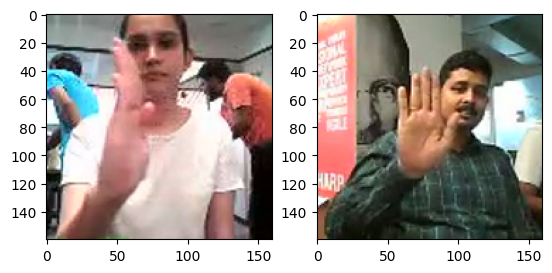

In [ ]:
#Sample code to confirm if generator functionality is working
test_gen_params=ModelParamTuner()
img_height=160
img_width=160
test_gen_params.init_image_params(img_height,img_width)
criteria = "ALL_FRAMES"
batch_size = 40
epochs = 1
selected_frames = 30
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
test_gen_params.init_hyper_params(criteria,selected_frames,batch_size,epochs)
g=generator(train_path,train_doc,test_gen_params)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
#Some sample images, after Cropping and resize
axes[0].imshow(batch_data[0,25,:,:,:])
axes[1].imshow(batch_data[2,25,:,:,:])

## I. Model with 3D convolutions

### Model1: Batch Size - 40, No.of Epoch 10, Considering all 30 frames, with default Dropout

- Run for small loops loop

In [ ]:
#Sample Model with less epochs
sample_model_params = ModelParamTuner()
img_height=160
img_width=160
sample_model_params.init_image_params(img_height,img_width)
criteria = "ALL_FRAMES"
batch_size = 40
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
epochs = 3
selected_frames = 30
sample_model_params.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
sample_model = get_model(sample_model_params)

In [ ]:
sample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 30, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 15, 80, 80, 32)   

In [ ]:
optimiser = Adam()
sample_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
sample_history = train_model(sample_model,sample_model_params)

steps_per_epoch:17, validation_steps:3
Source path =  /content/Project_data/train ; batch size = 40
Epoch 1/3
17/17 [==============================] - ETA: 0s - loss: 1.2967 - categorical_accuracy: 0.4977Source path =  /content/Project_data/val ; batch size = 40

Epoch 1: saving model to model_init_2023-08-0516_57_35.697413/model-00001-1.29667-0.49774-1.75642-0.25000.h5
17/17 [==============================] - 129s 7s/step - loss: 1.2967 - categorical_accuracy: 0.4977 - val_loss: 1.7564 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/3
17/17 [==============================] - ETA: 0s - loss: 0.7014 - categorical_accuracy: 0.7511
Epoch 2: saving model to model_init_2023-08-0516_57_35.697413/model-00002-0.70142-0.75113-2.53399-0.28000.h5
17/17 [==============================] - 107s 7s/step - loss: 0.7014 - categorical_accuracy: 0.7511 - val_loss: 2.5340 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/3
17/17 [==============================] - ETA: 0s - loss: 0.4121 - cat

- Run this model for more number of epochs (10), to understand the trend better.

In [ ]:
model_params1 = ModelParamTuner()
img_height=160
img_width=160
model_params1.init_image_params(img_height,img_width)
criteria = "ALL_FRAMES"
batch_size = 40
epochs = 10
selected_frames = 30
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params1.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model1 = get_model(model_params1)

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 80, 80, 32)   

In [ ]:
#Compile the Model
optimiser = Adam()
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history1 = train_model(model1,model_params1)

steps_per_epoch:17, validation_steps:3
Source path =  /content/Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 1.3638 - categorical_accuracy: 0.4555Source path =  /content/Project_data/val ; batch size = 40

Epoch 1: saving model to model_init_2023-08-0516_57_35.697413/model-00001-1.36380-0.45551-2.04762-0.21000.h5
17/17 [==============================] - 112s 7s/step - loss: 1.3638 - categorical_accuracy: 0.4555 - val_loss: 2.0476 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.7673 - categorical_accuracy: 0.7119
Epoch 2: saving model to model_init_2023-08-0516_57_35.697413/model-00002-0.76728-0.71192-3.09913-0.18000.h5
17/17 [==============================] - 122s 8s/step - loss: 0.7673 - categorical_accuracy: 0.7119 - val_loss: 3.0991 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.4750 - 

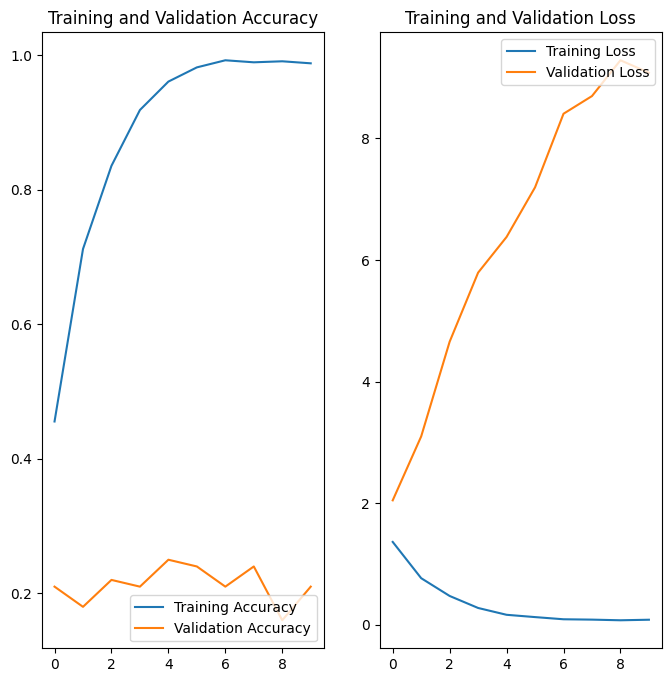

In [ ]:
plot_model(history1,model_params1.num_of_epochs)

**Observations:**
- Total params: 1,744,709
- As per the above graph, the training accuracy is `~99%` where as the  validation accuracy is `21%`, which is clearly indicating that the model is overfitting.
- Moreover, the training losss (`0.0840`), validation loss (`9.081`)  has a huge gap.


- Reducing batchsize to avoid overfitting.
- Reducing learning rate (to 0.0003), as  there is lot of oscillation in the validation accuraccy.

### Model2: Reducing BatchSize (30)

In [ ]:
model_params2 = ModelParamTuner()
img_height=160
img_width=160
model_params2.init_image_params(img_height,img_width)
criteria = "ALL_FRAMES"
batch_size = 30
epochs = 15
selected_frames = 30
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params2.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model2 = get_model(model_params2,0.30)

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_13 (Activation)  (None, 15, 80, 80, 32)   

In [ ]:
#Compile the Model
optimiser = Adam(learning_rate=0.0003)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history2 = train_model(model2,model_params2)

steps_per_epoch:23, validation_steps:4
Source path =  /home/dl_content/Upgrad DL/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.4722 - categorical_accuracy: 0.4042Source path =  /home/dl_content/Upgrad DL/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2023-08-0312_53_55.949909/model-00001-1.47215-0.40422-1.66750-0.15000.h5
23/23 [==============================] - 60s 3s/step - loss: 1.4722 - categorical_accuracy: 0.4042 - val_loss: 1.6675 - val_categorical_accuracy: 0.1500 - lr: 3.0000e-04
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 0.9050 - categorical_accuracy: 0.6365
Epoch 00002: saving model to model_init_2023-08-0312_53_55.949909/model-00002-0.90496-0.63650-2.28851-0.13000.h5
23/23 [==============================] - 54s 2s/step - loss: 0.9050 - categorical_accuracy: 0.6365 - val_loss: 2.2885 - val_categorical_accuracy: 0.1300 - lr: 3.0000e-04
Epoch 3/15
23/23 [=========

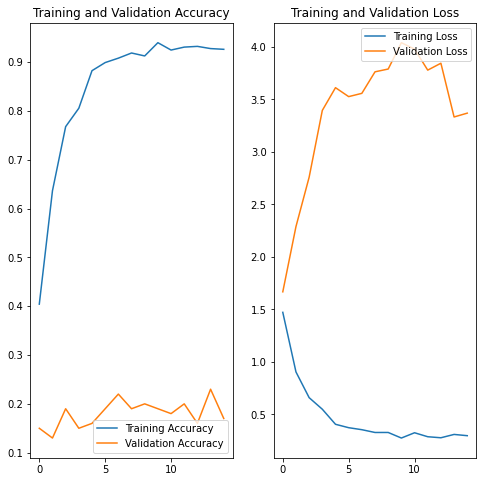

In [ ]:
plot_model(history2,model_params2.num_of_epochs)

**Observations:**
- Total params: 1,948,997
- Still the model is overfitting (Training accuracy is ~92% validation accuracy is reduced to 17%).
- In this case  the difference in training (0.2981) and validation loss (3.3682) is relatively reduced.


- Reducing the Number of frames, batch size, and increasing the dropout rate to avoid overfitting.

### Model3: Reducing the Number of Frames (20), Reducing Batch Size to 25, increasing the dropout rate

In [ ]:
model_params3 = ModelParamTuner()
img_height=160
img_width=160
model_params3.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 25
epochs = 15
selected_frames = 20
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params3.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model3 = get_model(model_params3,0.40)

In [ ]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_17 (Activation)  (None, 10, 80, 80, 32)   

In [ ]:
#Compile the Model
optimiser = Adam(learning_rate=0.0003)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history3 = train_model(model3,model_params3)

steps_per_epoch:27, validation_steps:4
Source path =  /home/dl_content/Upgrad DL/Project_data/train ; batch size = 25
Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 1.6565 - categorical_accuracy: 0.3394Source path =  /home/dl_content/Upgrad DL/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2023-08-0312_53_55.949909/model-00001-1.65645-0.33937-1.94113-0.16000.h5
27/27 [==============================] - 40s 1s/step - loss: 1.6565 - categorical_accuracy: 0.3394 - val_loss: 1.9411 - val_categorical_accuracy: 0.1600 - lr: 3.0000e-04
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.1442 - categorical_accuracy: 0.5234
Epoch 00002: saving model to model_init_2023-08-0312_53_55.949909/model-00002-1.14415-0.52338-2.50285-0.12000.h5
27/27 [==============================] - 38s 1s/step - loss: 1.1442 - categorical_accuracy: 0.5234 - val_loss: 2.5029 - val_categorical_accuracy: 0.1200 - lr: 3.0000e-04
Epoch 3/15
27/27 [=========

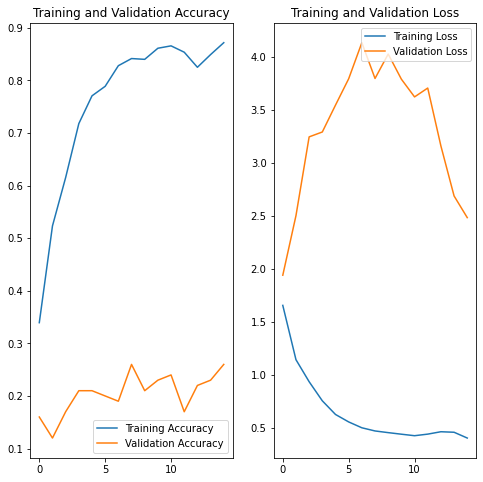

In [ ]:
plot_model(history3,model_params3.num_of_epochs)

**Observations:**
- Total params: 1,948,997
- Model is still overfitting (training accuracy `~87%`, validation accuracy `~26%`), and moreover the difference of training(`0.4051`), validation loss (`2.4843`) is increased as compared to previous model.


In order to solve this, image resolution, batch size is reduced. Increasing epochs to stabilize the model.

###  Model4: Reducing the image resolution to (130,130), and Reduce Batch Size to 20. Increasing the epochs in this case to 20

In [ ]:
model_params4 = ModelParamTuner()
img_height=130
img_width=130
model_params4.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 20
epochs = 20
selected_frames = 20
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params4.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model4 = get_model(model_params4,0.40,256)

In [ ]:
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 20, 130, 130, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 20, 130, 130, 16)  0         
                                                                 
 batch_normalization_35 (Bat  (None, 20, 130, 130, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 10, 65, 65, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 10, 65, 65, 32)    13856     
                                                                 
 activation_29 (Activation)  (None, 10, 65, 65, 32)   

In [ ]:
#Compile the Model
optimiser = Adam(learning_rate=0.0003)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history4 = train_model(model4,model_params4)

steps_per_epoch:34, validation_steps:5
Source path =  /home/dl_content/Upgrad DL/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5376 - categorical_accuracy: 0.4193Source path =  /home/dl_content/Upgrad DL/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2023-08-0312_53_55.949909/model-00001-1.53763-0.41931-2.43551-0.16000.h5
34/34 [==============================] - 34s 976ms/step - loss: 1.5376 - categorical_accuracy: 0.4193 - val_loss: 2.4355 - val_categorical_accuracy: 0.1600 - lr: 3.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9935 - categorical_accuracy: 0.5897
Epoch 00002: saving model to model_init_2023-08-0312_53_55.949909/model-00002-0.99352-0.58974-3.83870-0.15000.h5
34/34 [==============================] - 33s 1s/step - loss: 0.9935 - categorical_accuracy: 0.5897 - val_loss: 3.8387 - val_categorical_accuracy: 0.1500 - lr: 3.0000e-04
Epoch 3/20
33/34 [======

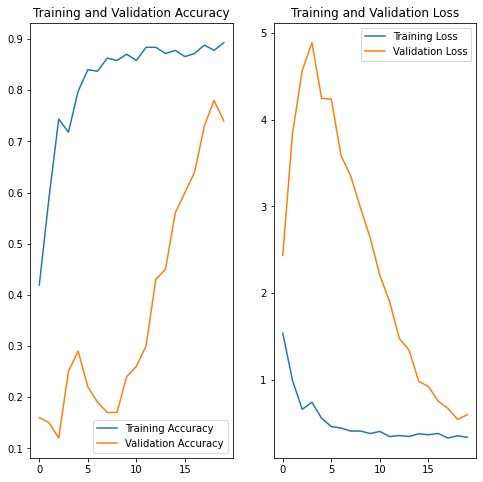

In [ ]:
plot_model(history4,model_params4.num_of_epochs)

**Observations:**
- Total params: 2,458,309
- In this case relatively the gap between training(`89%`) & validation accuracy(`74%`) is reduced relativel. But still it looked that `model is slightly overfitting`.
-The difference betwen training loss(`0.3388`) , validation loss (`0.5986`) is also reduced.

- Reducing the image resolution (120,120), and increasing the batch size, keeping the other configurations as is, in the previous model.

### Model5: Increasing Batch Size

In [ ]:
model_params5 = ModelParamTuner()
img_height=120
img_width=120
model_params5.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 25
epochs = 20
selected_frames = 20
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params5.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model5 = get_model(model_params5,0.40,256)

In [ ]:
model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_13 (Activation)  (None, 10, 60, 60, 32)   

In [ ]:
#Compile the Model
optimiser = Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
#With data augmentation
history5 = train_model(model5,model_params5)

steps_per_epoch:27, validation_steps:4
Source path =  /content/Project_data/train ; batch size = 25
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.4567 - categorical_accuracy: 0.4540Source path =  /content/Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_2023-08-0516_57_35.697413/model-00001-1.45667-0.45400-3.59044-0.21000.h5
27/27 [==============================] - 70s 3s/step - loss: 1.4567 - categorical_accuracy: 0.4540 - val_loss: 3.5904 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.8170 - categorical_accuracy: 0.7014
Epoch 2: saving model to model_init_2023-08-0516_57_35.697413/model-00002-0.81695-0.70136-6.63207-0.21000.h5
27/27 [==============================] - 66s 3s/step - loss: 0.8170 - categorical_accuracy: 0.7014 - val_loss: 6.6321 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.6639 - ca

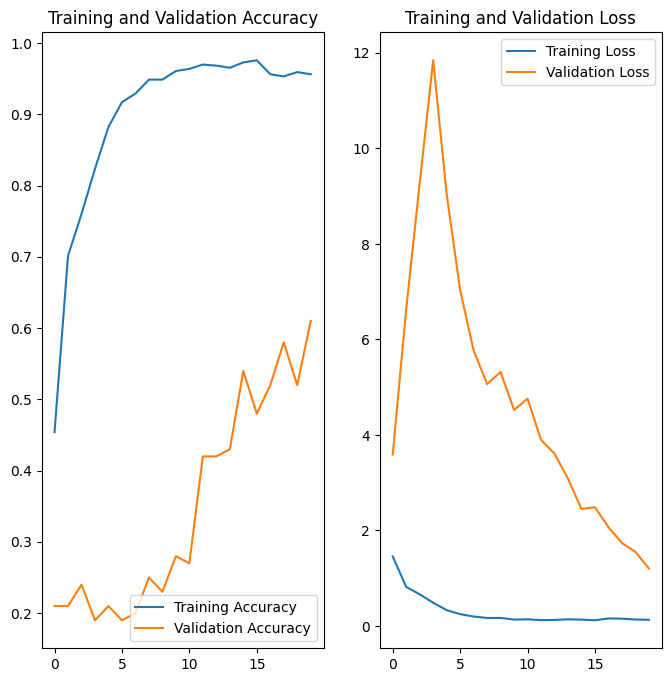

In [ ]:
plot_model(history5,model_params5.num_of_epochs)

**Observations:**
- Total params: 1,762,501
- In this case the training accuracy is `~95%` which is slightly improved as compared to earlier model, and validation accuracy is `61%`.  `So the model is still overfitting`
- The training (`0.1286`) and validation loss (`1.2040`) difference is increased in this model.



- Trying with Data Augmentation to see, if it can improve the model.

### Model 6: with Data Augmentation

In [ ]:
model_params6 = ModelParamTuner()
img_height=120
img_width=120
model_params6.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 20
epochs = 20
selected_frames = 20
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params6.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model6 = get_model(model_params6,0.40,256)

In [ ]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 10, 60, 60, 32)   

In [ ]:
#Compile the Model
optimiser = Adam()
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history6 = train_model(model6,model_params6, True)

steps_per_epoch:34, validation_steps:5
Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8662 - categorical_accuracy: 0.3002Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-08-0517_55_22.072759/model-00001-1.86623-0.30015-2.85790-0.16000.h5
34/34 [==============================] - 67s 2s/step - loss: 1.8662 - categorical_accuracy: 0.3002 - val_loss: 2.8579 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.6043 - categorical_accuracy: 0.3462
Epoch 2: saving model to model_init_2023-08-0517_55_22.072759/model-00002-1.60426-0.34615-4.36620-0.21000.h5
34/34 [==============================] - 63s 2s/step - loss: 1.6043 - categorical_accuracy: 0.3462 - val_loss: 4.3662 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.4927 - ca

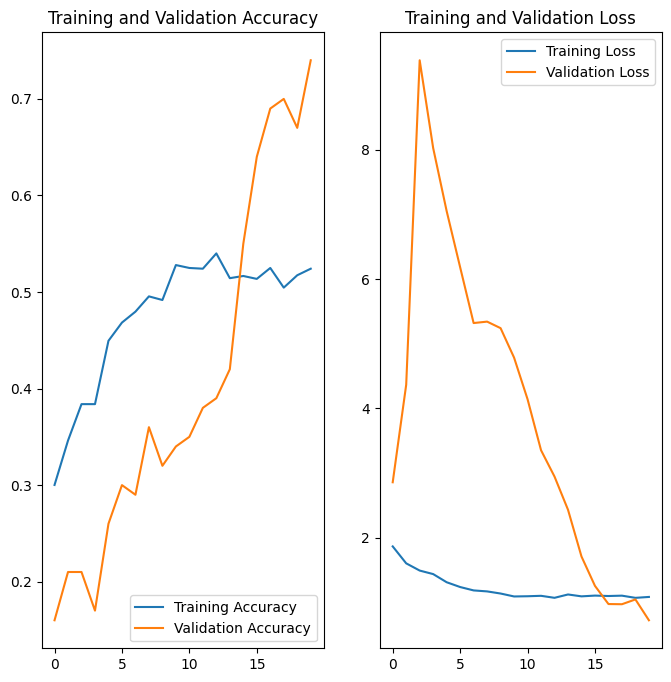

In [ ]:
plot_model(history6,model_params6.num_of_epochs)

**Observations:**
- Total params: 1,762,501
- In this case  the training accuracy (`52%`), is less than validation accuracy (`~74%`). Similar was the observation for training (`1.0849`) and validation loss(`0.7240`).
- **So this model is underfitting.**


- As data Augmentation is rather underfitting the model, rework on model 5 (without augmentation).

### Model 7:
- So far, Model 4 has given relatively better performance.
Reducing the dropout rate, with more epochs, to avoid overfitting problems

In [ ]:
model_params7 = ModelParamTuner()
img_height=130
img_width=130
model_params7.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 20
epochs = 25
selected_frames = 20
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params7.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model7 = get_model(model_params7,0.50,256)

In [ ]:
model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 130, 130, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 130, 130, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 130, 130, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 65, 65, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 65, 65, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 10, 65, 65, 32)   

In [ ]:
#Compile the Model
optimiser = Adam(learning_rate=0.0003)
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history7 = train_model(model7,model_params7)

steps_per_epoch:34, validation_steps:5
Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8559 - categorical_accuracy: 0.3424Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-08-0611_37_34.957013/model-00001-1.85593-0.34238-2.60796-0.21000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.8559 - categorical_accuracy: 0.3424 - val_loss: 2.6080 - val_categorical_accuracy: 0.2100 - lr: 3.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1548 - categorical_accuracy: 0.5520
Epoch 2: saving model to model_init_2023-08-0611_37_34.957013/model-00002-1.15478-0.55204-3.93664-0.21000.h5
34/34 [==============================] - 69s 2s/step - loss: 1.1548 - categorical_accuracy: 0.5520 - val_loss: 3.9366 - val_categorical_accuracy: 0.2100 - lr: 3.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0

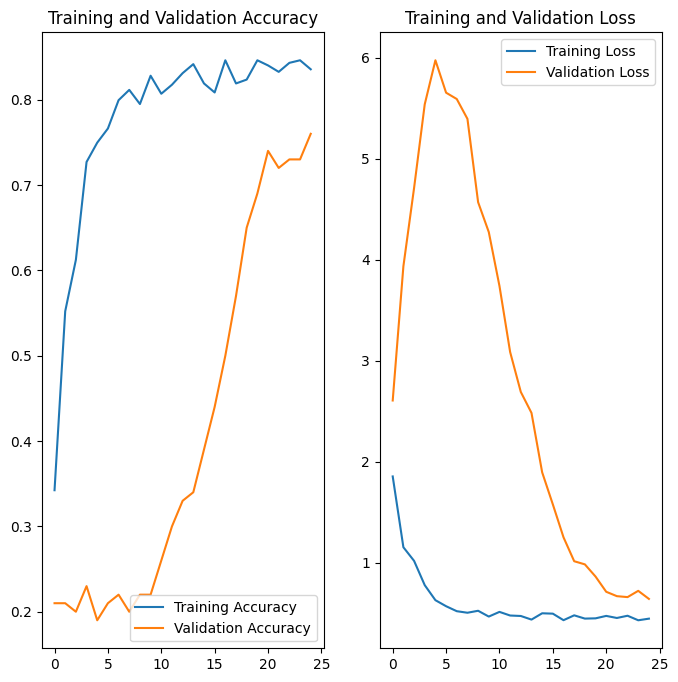

In [ ]:
plot_model(history7,model_params7.num_of_epochs)

**Observations:**
- Total params: 2,254,021
- As per the above model, the training accuracy is around `83.5%` and validation accuracy is `76%`.
- The training and validation loss is around `0.44` and `0.68` respectively.
- So `this looks to be the relatively better model, though it looks its still slightly overfitting`.

- As the number of parameters are slightly more in the above case, try changing the number of frames from 20 to 18, and the resolution from (130,130) to (120,120) keeping other configs as same in the above model, and retrying it.

## Model 8:


In [ ]:
model_params8 = ModelParamTuner()
img_height=120
img_width=120
model_params8.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 20
epochs = 25
selected_frames = 18
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params8.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model8 = get_model(model_params8,0.45,256)

In [ ]:
model8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_35 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 9, 60, 60, 32)     4128      
                                                                 
 activation_29 (Activation)  (None, 9, 60, 60, 32)    

In [ ]:
#Compile the Model
optimiser = Adam(learning_rate=0.0003)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history8 = train_model(model8,model_params8)

steps_per_epoch:34, validation_steps:5
Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6084 - categorical_accuracy: 0.3861Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-08-0713_04_54.720442/model-00001-1.60842-0.38612-2.02217-0.21000.h5
34/34 [==============================] - 39s 1s/step - loss: 1.6084 - categorical_accuracy: 0.3861 - val_loss: 2.0222 - val_categorical_accuracy: 0.2100 - lr: 3.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1385 - categorical_accuracy: 0.5747
Epoch 2: saving model to model_init_2023-08-0713_04_54.720442/model-00002-1.13846-0.57466-2.18715-0.22000.h5
34/34 [==============================] - 38s 1s/step - loss: 1.1385 - categorical_accuracy: 0.5747 - val_loss: 2.1872 - val_categorical_accuracy: 0.2200 - lr: 3.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.8

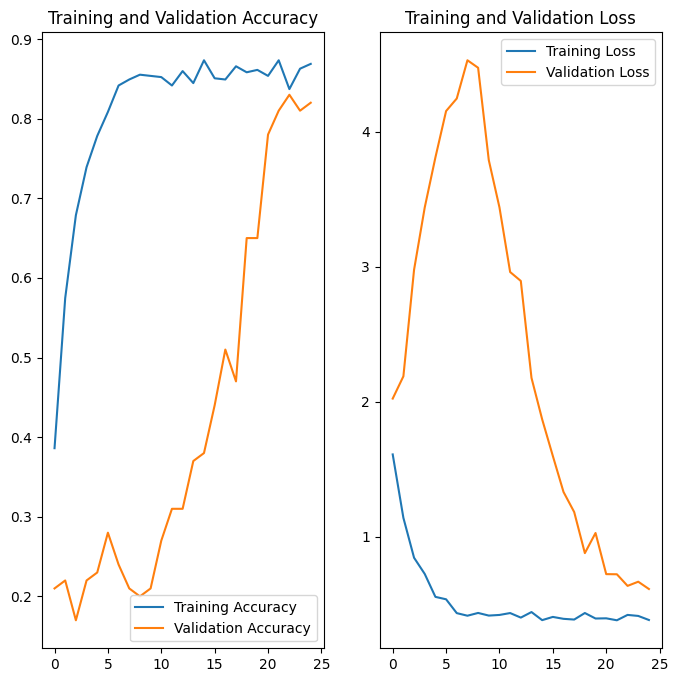

In [ ]:
plot_model(history8,model_params8.num_of_epochs)

**Observations:**
- Total params: 1,762,501
- With the reduction of parameters, and decreasing the number of frames, this was the best model where the training accuracy is `~86%` and validation accuracy is ~82%.
- Moreover, the gap between model training (`0.3814`) and validation loss(`0.6111`) also is relatively smaller.
- `So this is the best model using Conv3D, and overfitting problem is also addressed, with relatively fewer parameters.`

## II. CNN + RNN Model (Using LSTM)

In [21]:
# CNN + RNN Model
# In this model 5 convolution layers (16,32,64,128,256) are used followed by LSTM
# Drop out, Dense layer neurons are tunable parameter
def get_CNN_RNN_Model(model_params,drop_out = 0.25,neurons=128):
    model = Sequential()

    #1st Layer
    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(len(model_params.img_indexes),
                                               model_params.img_height,model_params.img_width,
                                               model_params.channel_size)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #2nd Layer
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(neurons))
    model.add(Dropout(drop_out))

    model.add(Dense(neurons,activation='relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(model_params.output_classes, activation='softmax'))
    return model

### Model 1

In [ ]:
model_params_cnn_rnn = ModelParamTuner()
img_height=120
img_width=120
model_params_cnn_rnn.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 20
epochs = 20
selected_frames = 20
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params_cnn_rnn.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [ ]:
model_cnn_rnn = get_CNN_RNN_Model(model_params_cnn_rnn)

In [ ]:
model_cnn_rnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 60, 60, 32) 

In [ ]:
#Compile the Model
optimiser = Adam()
model_cnn_rnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history_model_cnn_rnn = train_model(model_cnn_rnn,model_params_cnn_rnn)

steps_per_epoch:34, validation_steps:5
Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4245 - categorical_accuracy: 0.3816Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-08-0517_55_22.072759/model-00001-1.42453-0.38160-1.65823-0.25000.h5
34/34 [==============================] - 78s 2s/step - loss: 1.4245 - categorical_accuracy: 0.3816 - val_loss: 1.6582 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1597 - categorical_accuracy: 0.5189
Epoch 2: saving model to model_init_2023-08-0517_55_22.072759/model-00002-1.15970-0.51885-2.16641-0.18000.h5
34/34 [==============================] - 69s 2s/step - loss: 1.1597 - categorical_accuracy: 0.5189 - val_loss: 2.1664 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1028 - ca

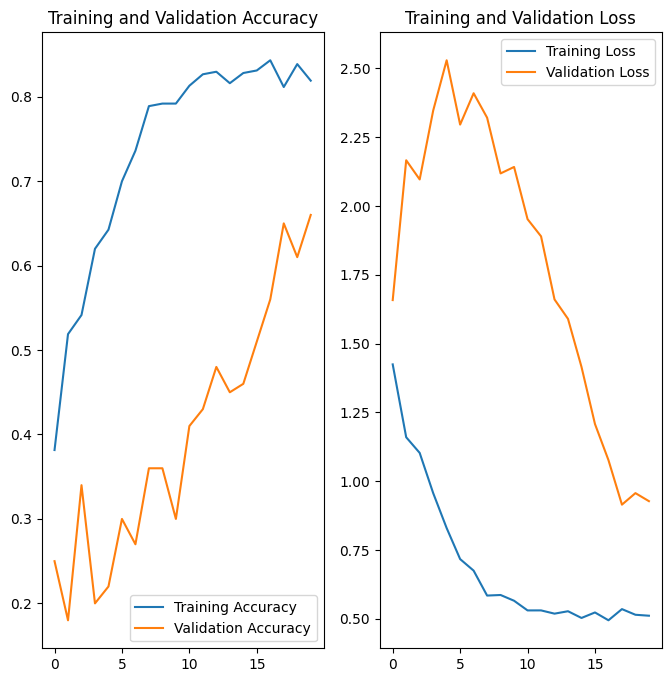

In [ ]:
plot_model(history_model_cnn_rnn,model_params_cnn_rnn.num_of_epochs)

**Observations:**
- Total params: 1,657,445
- With the above CNN + RNN(LSTM) model, the training accuracy is `~82%`, and validation accurayc is `66%`
- Training loss is (`0.5111`), and validation loss is (`0.9275`)
- So the initial model is overfitting.

### Model 2:
- Increasing dropout rate, reducing framesize, and increasing the number of epochs.

In [22]:
model_params_cnn_rnn2 = ModelParamTuner()
img_height=120
img_width=120
model_params_cnn_rnn2.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 20
epochs = 25
selected_frames = 18
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params_cnn_rnn2.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [24]:
model_cnn_rnn2 = get_CNN_RNN_Model(model_params_cnn_rnn2,0.35,128)

In [25]:
model_cnn_rnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32)  

In [26]:
#Compile the Model
optimiser = Adam()
model_cnn_rnn2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [27]:
history_model_cnn_rnn2 = train_model(model_cnn_rnn2,model_params_cnn_rnn2)

steps_per_epoch:34, validation_steps:5
Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5397 - categorical_accuracy: 0.3122Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-08-0718_02_55.629816/model-00001-1.53966-0.31222-1.77957-0.21000.h5
34/34 [==============================] - 69s 2s/step - loss: 1.5397 - categorical_accuracy: 0.3122 - val_loss: 1.7796 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2542 - categorical_accuracy: 0.4992
Epoch 2: saving model to model_init_2023-08-0718_02_55.629816/model-00002-1.25417-0.49925-2.05663-0.19000.h5
34/34 [==============================] - 45s 1s/step - loss: 1.2542 - categorical_accuracy: 0.4992 - val_loss: 2.0566 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1804 - ca

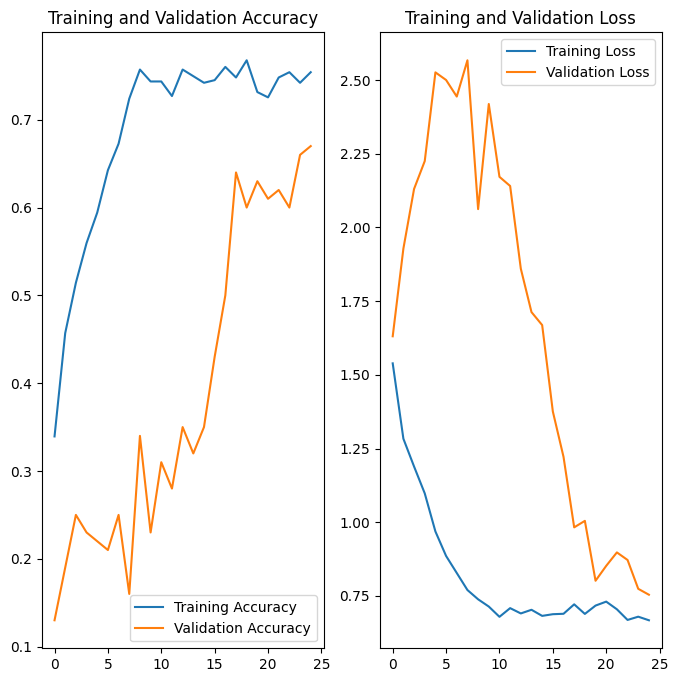

In [33]:
plot_model(history_model_cnn_rnn2,model_params_cnn_rnn2.num_of_epochs)

**Observations:**
- Total params: 1,657,445
- With the above CNN + RNN(LSTM) model, the training accuracy is `~77%`, and validation accurayc is `69%`
- Training loss is (`0.6497`), and validation loss is (`0.7692`)
- So the initial model is overfitting.

### Model3: With GRU

In [20]:
# In this model 5 convolution layers (16,32,64,128,256) are used followed by LSTM
# Drop out, Dense layer neurons are tunable parameter
def get_CNN_RNN_Model2(model_params,drop_out = 0.25,neurons=128):
    model = Sequential()

    #1st Layer
    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(len(model_params.img_indexes),
                                               model_params.img_height,model_params.img_width,
                                               model_params.channel_size)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #2nd Layer
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(neurons))
    model.add(Dropout(drop_out))

    model.add(Dense(neurons,activation='relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(model_params.output_classes, activation='softmax'))
    return model

In [21]:
model_params_cnn_rnn3 = ModelParamTuner()
img_height=120
img_width=120
model_params_cnn_rnn3.init_image_params(img_height,img_width)
criteria = "LINEARLY_SPACED"
batch_size = 20
epochs = 25
selected_frames = 18
# Initially try with minimal epochs with smaller batch size, to confirm if model is working
model_params_cnn_rnn3.init_hyper_params(criteria,selected_frames,batch_size,epochs)

In [22]:
model_cnn_rnn3 = get_CNN_RNN_Model2(model_params_cnn_rnn3,0.35,128)

In [23]:
model_cnn_rnn3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)   1

In [24]:
#Compile the Model
optimiser = Adam()
model_cnn_rnn3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [25]:
history_model_cnn_rnn3 = train_model(model_cnn_rnn3,model_params_cnn_rnn3)

steps_per_epoch:34, validation_steps:5
Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.4901 - categorical_accuracy: 0.3560Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-08-0815_27_04.840798/model-00001-1.49007-0.35596-1.95245-0.22000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.4901 - categorical_accuracy: 0.3560 - val_loss: 1.9524 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2209 - categorical_accuracy: 0.5023
Epoch 2: saving model to model_init_2023-08-0815_27_04.840798/model-00002-1.22090-0.50226-2.26500-0.31000.h5
34/34 [==============================] - 49s 1s/step - loss: 1.2209 - categorical_accuracy: 0.5023 - val_loss: 2.2650 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0793 - ca

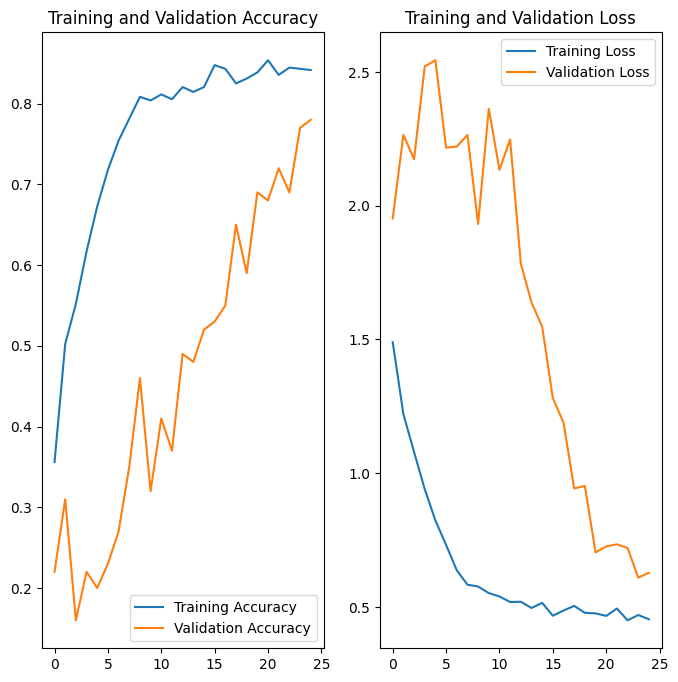

In [26]:
plot_model(history_model_cnn_rnn3,model_params_cnn_rnn3.num_of_epochs)

**Observations:**
- Total params: 1,346,405
- With the above CNN + RNN(GRU) model, the training accuracy is `~84%`, and validation accurayc is `78%`
- Training loss is (`0.4542`), and validation loss is (`0.6279`)
- So the  model is doing relaatively better, with fewer parameters.